In [1]:
import torch.nn as nn
import torch

# Multi Head Attention Layer 구현

#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [2]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self,hidden_dim,n_heads,dropout_ratio,device):
        super().__init__()
        
        assert hidden_dim % n_heads == 0
        
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads
        
        self.fc_q = nn.Linear(hidden_dim,hidden_dim)
        self.fc_k = nn.Linear(hidden_dim,hidden_dim)
        self.fc_v = nn.Linear(hidden_dim,hidden_dim)
        
        self.fc_o = nn.Linear(hidden_dim,hidden_dim)
        
        self.dropout = nn.Dropout(dropout_ratio)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self,query,key,value,mask=None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        
        energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale

        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)
        
        attention = torch.softmax(energy,dim=-1)
        
        x = torch.matmul(self.dropout(attention),V)
        
        x = x.permute(0,2,1,3).contiguous()
        
        x = x.view(batch_size,-1,self.hidden_dim)
        
        x = self.fc_o(x)
        
        return x,attention

In [3]:
multiheadattention = MultiHeadAttentionLayer(hidden_dim = 768, n_heads = 8, dropout_ratio = 0.1,device = 'cpu')

In [4]:
query = torch.rand(8,197,768)
key = torch.rand(8,197,768)
value = torch.rand(8,197,768)

x, attention = multiheadattention.forward(query,key,value)
print(x.size(),attention.size())

torch.Size([8, 197, 768]) torch.Size([8, 8, 197, 197])


# PositionwiseFeedforwardLayer 구현

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [5]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()
        self.fc_1 = nn.Linear(hidden_dim,pf_dim)
        self.fc_2 = nn.Linear(pf_dim,hidden_dim)
        
        self.dropout = nn.Dropout(dropout_ratio)
        
    def forward(self,x):
        x = self.fc_1(x)
        x = torch.relu(x)
        x = self.fc_2(x)
        
        return x

In [6]:
positionwisefeedforwardlayer = PositionwiseFeedforwardLayer(hidden_dim = 768,pf_dim = 2048, dropout_ratio=0.1)
z = torch.rand(8,197,768)
z = positionwisefeedforwardlayer.forward(z)
print(z.size())

torch.Size([8, 197, 768])


# EncoderLayer 구현

#### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio,device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention =MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)
    def forward(self, src ,src_mask):
        #src = batch_size, src_len, hidden_dim
        #src_mask = batch_size, src_len
        
        _src, _ = self.self_attention(src,src,src,src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

In [8]:
encoderlayer = EncoderLayer(hidden_dim = 768, n_heads = 8, pf_dim = 2048, dropout_ratio = 0.1, device = 'cpu')
src = torch.rand(8,197,768)
src_mask = torch.rand(8,197,197)
src = encoderlayer.forward(src,src_mask)
print(src.size())

torch.Size([8, 197, 768])


# Encoder 구현

#### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio,device,max_length=200):
        super().__init__()
        
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim,n_heads,pf_dim,dropout_ratio,device) for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self,src,src_mask):
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src,src_mask)
        return src

In [10]:
encoder = Encoder(input_dim=700, hidden_dim = 768, n_layers = 4, n_heads = 8, pf_dim = 2048, dropout_ratio = 0.1, device = 'cpu')
src = torch.rand(8,100).int()
src_mask = torch.rand(8,1,1,100).int()
print(encoder)
src = encoder.forward(src,src_mask)
print(src.shape)

Encoder(
  (tok_embedding): Embedding(700, 768)
  (pos_embedding): Embedding(200, 768)
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_feedforward): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=768, out_features=2048, bias=True)
        (fc_2): Linear(in_features=2048, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )

In [11]:
tok_embedding = nn.Embedding(200, 768)
pos_embedding = nn.Embedding(200, 768)

z = torch.rand(8,197).int()
pos = torch.arange(0,197).unsqueeze(0).repeat(8,1)
p = tok_embedding(z)
k = pos_embedding(pos)
print(p.shape,k.shape)

torch.Size([8, 197, 768]) torch.Size([8, 197, 768])


# DecoderLayer 구현

#### **디코더(Decoder) 레이어 아키텍처**

* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)
        
    def forward(self,trg,enc_src,trg_mask,src_mask):
        
        _trg,_ = self.self_attention(trg,trg,trg,trg_mask)
        
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.enc_attn_layer_norm(trg+self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg,attention

In [13]:
decoderlayer = DecoderLayer(hidden_dim = 768, n_heads = 768, pf_dim = 2048, dropout_ratio = 0.1, device = 'cpu')
trg = torch.rand(8,197,768)
enc_src = torch.rand(8,197,768)
trg_mask = torch.rand(8,1,197,197)
src_mask = torch.rand(8,1,1,197)
trg, attention = decoderlayer.forward(trg, enc_src, trg_mask, src_mask)
print(trg.shape)
print(attention.shape)

torch.Size([8, 197, 768])
torch.Size([8, 768, 197, 197])


# Decoder 구현 

#### **디코더(Decoder) 아키텍처**

* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=200):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim,hidden_dim)
        self.pos_embedding = nn.Embedding(max_length,hidden_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hidden_dim,output_dim)
        
        self.dropout = nn.Dropout(dropout_ratio)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
            
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output = self.fc_out(trg)
            
        return output, attention

In [15]:
decoder = Decoder(output_dim = 28, hidden_dim = 768, n_layers = 4, n_heads = 8, pf_dim = 2048, dropout_ratio = 0.1, device ='cpu')
trg = torch.rand(8,197).int()
enc_src = torch.rand(8,197,768)
trg_mask = torch.rand(8,1,197,197)
src_mask = torch.rand(8,1,1,197)
trg, attention = decoder.forward(trg, enc_src, trg_mask, src_mask)
print(trg.shape)
print(attention.shape)

torch.Size([8, 197, 28])
torch.Size([8, 8, 197, 197])


# Transformer 구현

#### **트랜스포머(Transformer) 아키텍처**

* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

In [16]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self,src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self,trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
    
    def forward(self,src,trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src,src_mask)
        
        output,attention = self.decoder(trg,enc_src,trg_mask,src_mask)
        
        return output, attention
        

In [17]:
# INPUT_DIM = len(SRC.vocab)
# OUTPUT_DIM = len(TRG.vocab)
# HIDDEN_DIM = 256
# ENC_LAYERS = 3
# DEC_LAYERS = 3
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

In [18]:
enc = Encoder(100, 768, 12, 8, 2048, 0.1, 'cpu')
dec = Decoder(100, 768, 12, 8, 2048, 0.1, 'cpu')

transformer = Transformer(enc,dec,0,0,'cpu')

In [19]:
transformer

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(100, 768)
    (pos_embedding): Embedding(200, 768)
    (layers): ModuleList(
      (0-11): 12 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=768, out_features=768, bias=True)
          (fc_k): Linear(in_features=768, out_features=768, bias=True)
          (fc_v): Linear(in_features=768, out_features=768, bias=True)
          (fc_o): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=768, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
  

In [20]:
src = torch.rand(8,197).int()
trg = torch.rand(8,197).int()
output,attention = transformer.forward(src,trg)
print(output.shape,attention.shape)

torch.Size([8, 197, 100]) torch.Size([8, 8, 197, 197])


# 데이터셋 만들기

In [21]:
!python -m spacy download en
!python -m spacy download de

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
      --------------------------------------- 0.3/12.8 MB 3.5 MB/s eta 0:00:04
     - -------------------------------------- 0.6/12.8 MB 4.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/12.8 MB 5.5 MB/s eta 0:00:03
     -------- ------------------------------- 2.7/12.8 MB 11.4 MB/s eta 0:00:01
     ----------- ---------------------------- 3.7/12.8 MB 14.8 MB/s eta 0:00:01
     ----------- ---------------------------- 3.7/12.8 MB 14.8 MB/s eta 0:00:01
     --------------------------- ------------ 8.8/12.8 MB 23.6 MB/s eta 0:00:01
     ----------------------------- ---------- 9.3/12.8 MB 24.9 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 46.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 43.5 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprec

In [22]:
import spacy
spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de_core_news_sm') # 독일어 토큰화(tokenization)

In [23]:
# 간단히 토큰화(tokenization) 기능 써보기
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


In [24]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [25]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

In [26]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

downloading training.tar.gz


.data\multi30k\training.tar.gz: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.21M/1.21M [00:03<00:00, 359kB/s]


downloading validation.tar.gz


.data\multi30k\validation.tar.gz: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46.3k/46.3k [00:00<00:00, 95.9kB/s]


downloading mmt_task1_test2016.tar.gz


.data\multi30k\mmt_task1_test2016.tar.gz: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66.2k/66.2k [00:00<00:00, 93.4kB/s]


In [27]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [28]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


In [29]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


In [30]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [31]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [32]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 25])
인덱스 0: 2
인덱스 1: 8
인덱스 2: 26
인덱스 3: 16
인덱스 4: 11
인덱스 5: 71
인덱스 6: 188
인덱스 7: 10
인덱스 8: 382
인덱스 9: 51
인덱스 10: 708
인덱스 11: 212
인덱스 12: 7
인덱스 13: 6
인덱스 14: 313
인덱스 15: 128
인덱스 16: 27
인덱스 17: 6
인덱스 18: 51
인덱스 19: 86
인덱스 20: 4
인덱스 21: 3
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1


# 모델 준비

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [34]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,089,541 trainable parameters


In [36]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(200, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [37]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [38]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [39]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [40]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 6s
	Train Loss: 4.192 | Train PPL: 66.170
	Validation Loss: 2.956 | Validation PPL: 19.214
Epoch: 02 | Time: 0m 5s
	Train Loss: 2.736 | Train PPL: 15.430
	Validation Loss: 2.238 | Validation PPL: 9.370
Epoch: 03 | Time: 0m 5s
	Train Loss: 2.168 | Train PPL: 8.743
	Validation Loss: 1.943 | Validation PPL: 6.980
Epoch: 04 | Time: 0m 5s
	Train Loss: 1.831 | Train PPL: 6.240
	Validation Loss: 1.791 | Validation PPL: 5.994
Epoch: 05 | Time: 0m 5s
	Train Loss: 1.595 | Train PPL: 4.928
	Validation Loss: 1.696 | Validation PPL: 5.452
Epoch: 06 | Time: 0m 5s
	Train Loss: 1.413 | Train PPL: 4.107
	Validation Loss: 1.652 | Validation PPL: 5.219
Epoch: 07 | Time: 0m 5s
	Train Loss: 1.268 | Train PPL: 3.555
	Validation Loss: 1.633 | Validation PPL: 5.118
Epoch: 08 | Time: 0m 5s
	Train Loss: 1.146 | Train PPL: 3.146
	Validation Loss: 1.623 | Validation PPL: 5.067
Epoch: 09 | Time: 0m 5s
	Train Loss: 1.040 | Train PPL: 2.830
	Validation Loss: 1.621 | Validation PPL: 5.057
Epoch: 

In [42]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.686 | Test PPL: 5.395


In [43]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [44]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her son enjoying a beautiful day outside . <eos>


In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\tm011\AppData\Local\Temp\ipykernel_25560\3016299776.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
C:\Users\tm011\AppData\Local\Temp\ipykernel_25560\3016299776.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


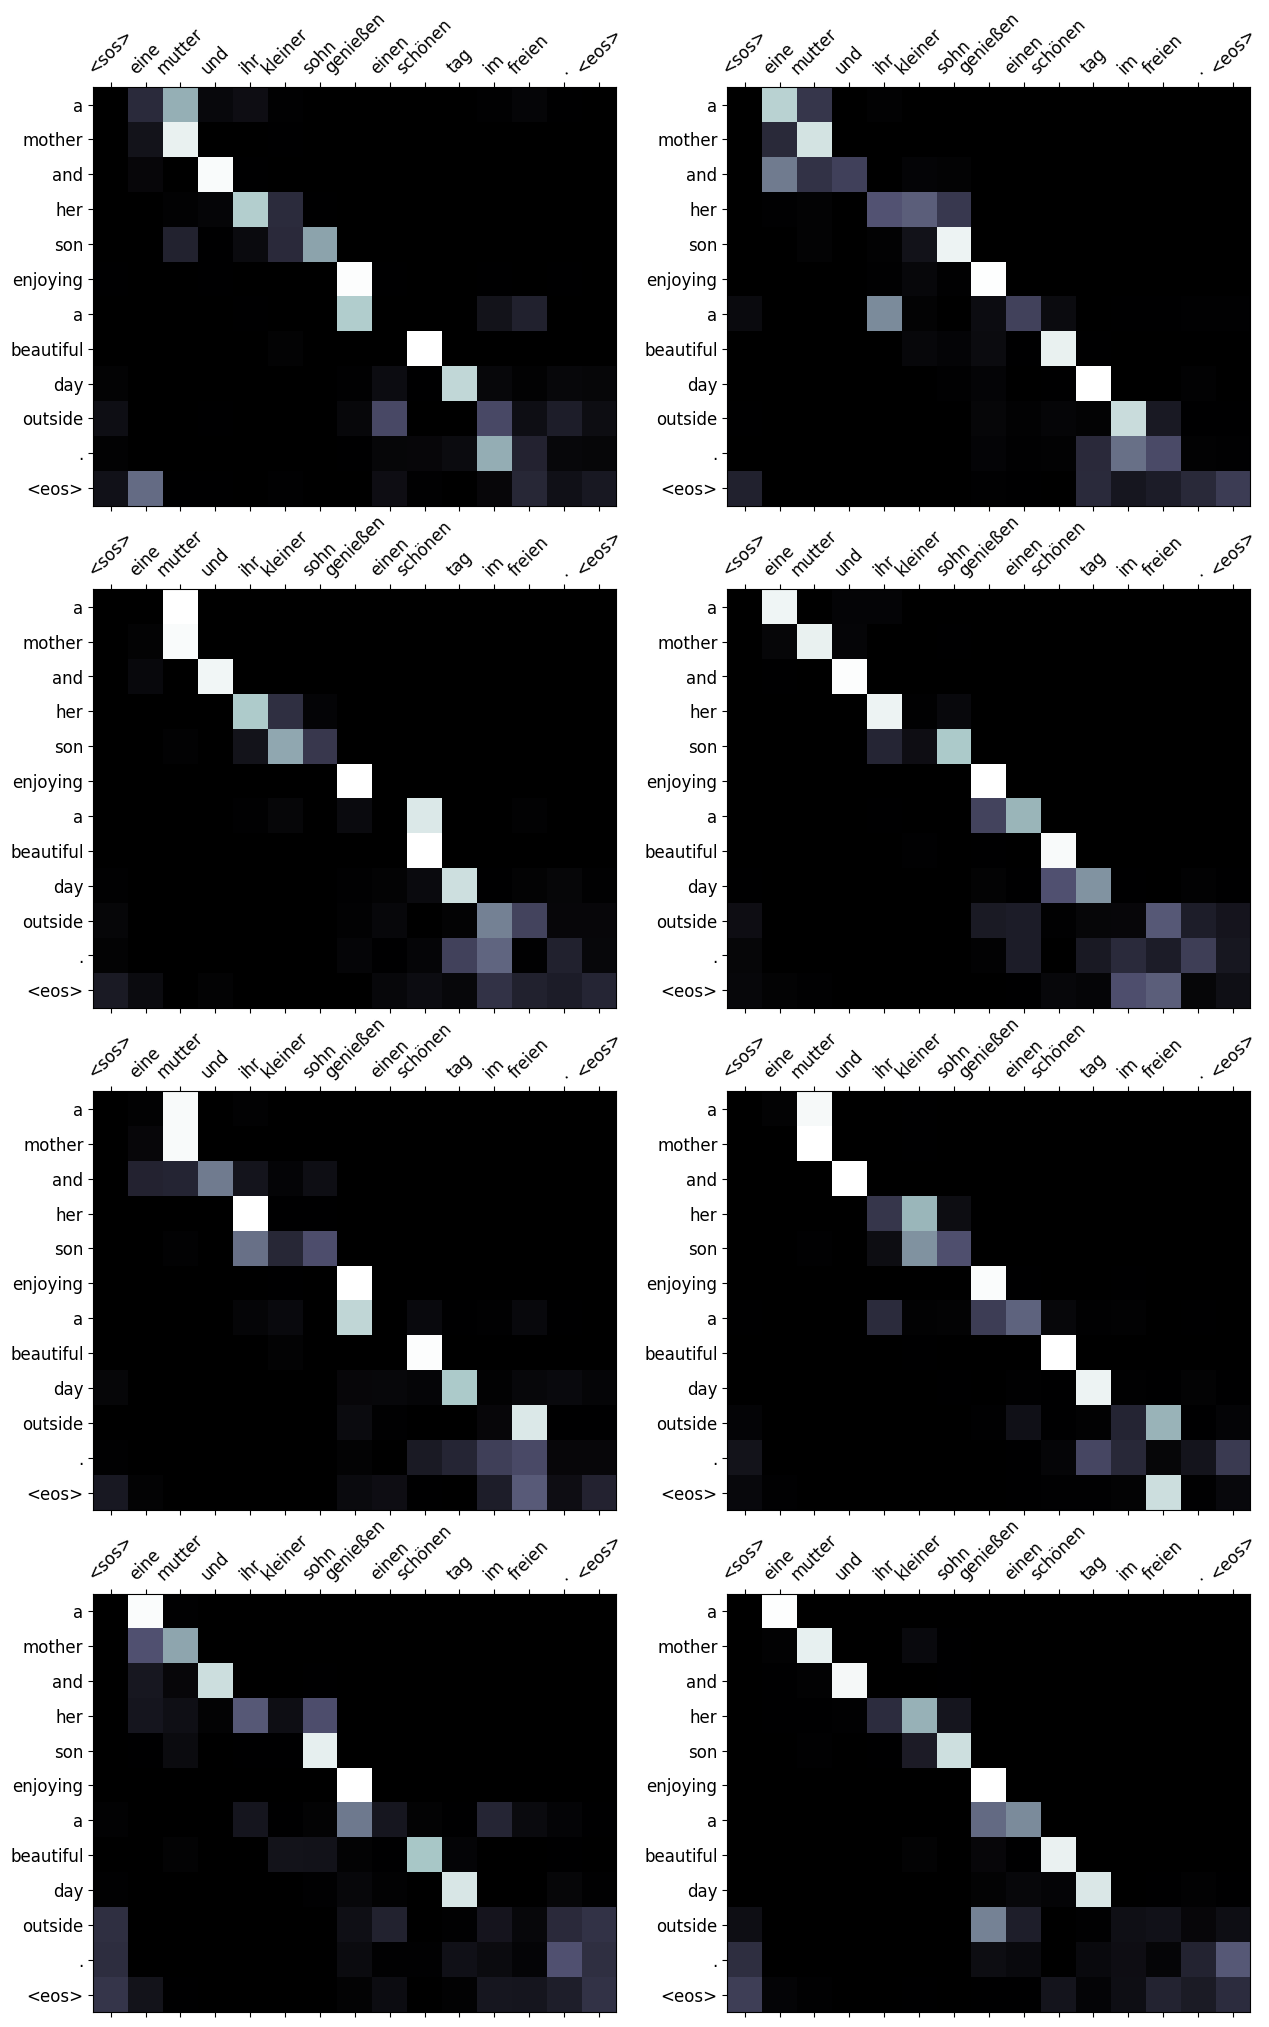

In [48]:
display_attention(src, translation, attention)

In [49]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [50]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'are', 'sitting', 'in', 'blue', 'chairs', 'laid', 'out', 'on', 'blue', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
예측: ['all', 'in', 'the', 'group', 'of', 'people', 'are', 'standing', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
예측: ['a', 'goalie', 'in', 'a', 'yellow', 'jersey', 'is', 'shielding', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
예측: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
예측: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[600/1000]
예측: ['a', 'group', 'of', 'men', 'sit', 'and', 'talk', 'b